In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
file_path = "/content/drive/MyDrive/IoT/Proj/weather-data.csv"
data=pd.read_csv(file_path, delimiter=',',header=0,skipinitialspace=True)
data.head(50)

,timestamp,Temperature
0,20230401T0000,9.200245
1,20230401T0100,8.800245
2,20230401T0200,8.740245
3,20230401T0300,9.040245
4,20230401T0400,8.880245
5,20230401T0500,8.690246
6,20230401T0600,8.630245
7,20230401T0700,8.430245
8,20230401T0800,8.690246
9,20230401T0900,8.860246


In [ ]:
temperature = np.array(data['Temperature'])
num_periods = 24
f_horizon = 1
x_data = temperature[:(len(temperature)-(num_periods*2))]
# print(x_data)
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = temperature[1:(len(temperature)-(num_periods*2))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print(y_batches.shape)

(28, 24, 1)


In [ ]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = temperature[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
X_test, Y_test = test_data(temperature, f_horizon, 24*2)
print(X_test.shape)

(2, 24, 1)


In [ ]:
tf.reset_default_graph()
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
dropout_keep_prob = tf.placeholder(tf.float32)

X = tf.placeholder(tf.float32, [None, num_periods, 1])
Y = tf.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf.keras.layers.SimpleRNNCell(units=rnn_size, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)


output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])
print(logit)

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf.global_variables_initializer()

Tensor("softmax/BiasAdd:0", shape=(?, 1), dtype=float32)


<ipython-input-50-c8c13c1d8745>:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logit=tf.layers.dense(output, 1, name="softmax")


In [ ]:
epochs = 1000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "/content/drive/MyDrive/IoT/Proj/weather.ckpt")

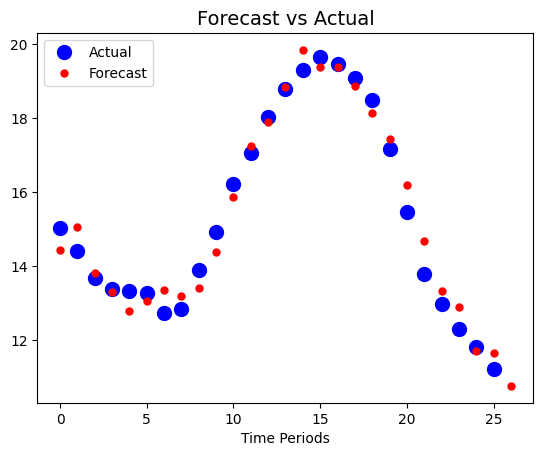

In [ ]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()

In [ ]:
with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "/content/drive/MyDrive/IoT/Proj/weather.ckpt")
    predict=sess.run(outputs, feed_dict={X: X_test})
print(predict)

[[[14.443749 ]
  [15.05755  ]
  [13.816291 ]
  [13.314017 ]
  [12.782257 ]
  [13.0537405]
  [13.347351 ]
  [13.179908 ]
  [13.412278 ]
  [14.392229 ]
  [15.864776 ]
  [17.254414 ]
  [17.908133 ]
  [18.83626  ]
  [19.852837 ]
  [19.402372 ]
  [19.37736  ]
  [18.874113 ]
  [18.132883 ]
  [17.43711  ]
  [16.202324 ]
  [14.694349 ]
  [13.319152 ]
  [12.89647  ]]

 [[11.705299 ]
  [11.646786 ]
  [10.759782 ]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]]]


In [ ]:
print(y_pred)

[[[14.443749 ]
  [15.05755  ]
  [13.816291 ]
  [13.314017 ]
  [12.782257 ]
  [13.0537405]
  [13.347351 ]
  [13.179908 ]
  [13.412278 ]
  [14.392229 ]
  [15.864776 ]
  [17.254414 ]
  [17.908133 ]
  [18.83626  ]
  [19.852837 ]
  [19.402372 ]
  [19.37736  ]
  [18.874113 ]
  [18.132883 ]
  [17.43711  ]
  [16.202324 ]
  [14.694349 ]
  [13.319152 ]
  [12.89647  ]]

 [[11.705299 ]
  [11.646786 ]
  [10.759782 ]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]
  [       nan]]]
